# Transfer Learning

- This notebook shows how to use one fitted model stored in a `Forecaster` object to make predictions on a separate time series.
- Requires `>=0.19.0`
- As of 0.19.0, only univariate sklearn models are supported for this type of process. Tensforflow, then multivariate sklearn, then the rest of the model types will be worked on subsequently.

In [1]:
from scalecast.Forecaster import Forecaster
from scalecast.util import infer_apply_Xvar_selection, find_optimal_transformation
from scalecast.Pipeline import Pipeline, Transformer, Reverter
from scalecast import GridGenerator
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
GridGenerator.get_example_grids()

## Initiate the First Forecaster Object

This series ends December, 2020.

In [3]:
df = pdr.get_data_fred(
    'HOUSTNSA',
    start = '1959-01-01',
    end = '2020-12-31',
)

df.tail()

,HOUSTNSA
DATE,
2020-08-01,122.5
2020-09-01,126.3
2020-10-01,131.2
2020-11-01,117.8
2020-12-01,115.1


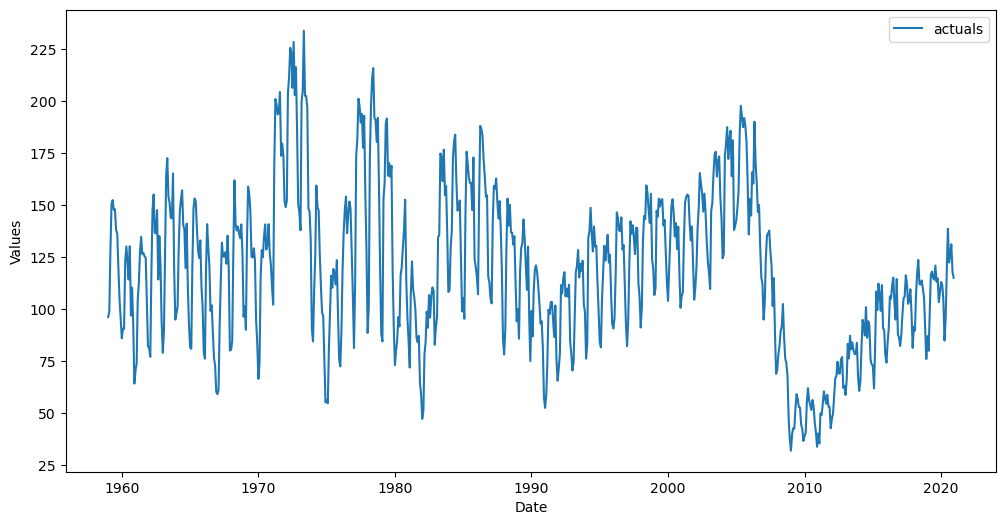

In [4]:
f = Forecaster(
    y = df.iloc[:,0],
    current_dates = df.index,
    future_dates = 24,
    #cis=True,
    #test_length = 24, # transferring confidence intervals is also possible!
)

f.plot()
plt.show()

### Automatically add Xvars to the object

In [5]:
f.auto_Xvar_select()
f

Forecaster(
    DateStartActuals=1959-01-01T00:00:00.000000000
    DateEndActuals=2020-12-01T00:00:00.000000000
    Freq=MS
    N_actuals=744
    ForecastLength=24
    Xvars=['AR1', 'AR2', 'AR3', 'AR4']
    TestLength=0
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

### Fit an XGBoost Model and Make Predictions

In [6]:
f.set_estimator('xgboost')
f.ingest_grid('xgboost')
f.limit_grid_size(10)
f.cross_validate(k=3,test_length=48)
f.auto_forecast()

### View the Forecast

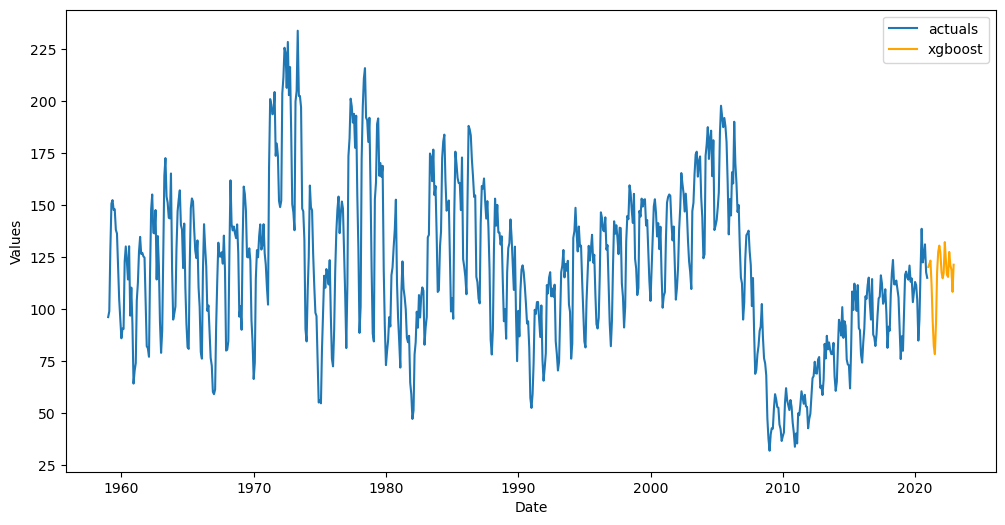

In [7]:
f.plot()
plt.show()

## Initiate the Second Forecaster Object

- Later, if we have more data streaming in, instead of refitting a model, we can use the already-fitted model to make the predictions. This updated series is through June, 2023
- You can use an updated version of the original series, you can use the same series with an extended Forecast horizon, or you can use an entirely different series (as long as it's the same frequency) to perform this process

In [8]:
df_new = pdr.get_data_fred(
    'HOUSTNSA',
    start = '1959-01-01',
    end = '2023-06-30',
)

df_new.tail()

,HOUSTNSA
DATE,
2023-02-01,103.2
2023-03-01,114.0
2023-04-01,121.7
2023-05-01,146.0
2023-06-01,130.0


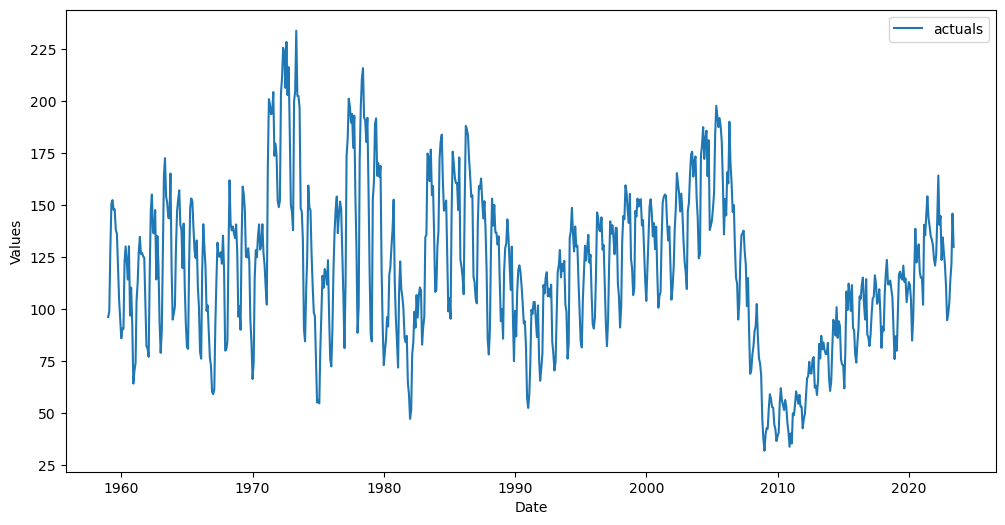

In [9]:
f_new = Forecaster(
    y = df_new.iloc[:,0],
    current_dates = df_new.index,
    future_dates = 24,
    #cis=True,
    #test_length = 24,
)

f_new.plot()
plt.show()

### Add the same Xvars to the new Forecaster object
- The helper function below can assist when you automatically added Xvars
- If you manually added Xvars, you can wrap the selection process in a function and run this new `Forecaster` object through the same function.

In [10]:
f_new = infer_apply_Xvar_selection(infer_from=f,apply_to=f_new)
f_new

Forecaster(
    DateStartActuals=1959-01-01T00:00:00.000000000
    DateEndActuals=2023-06-01T00:00:00.000000000
    Freq=MS
    N_actuals=774
    ForecastLength=24
    Xvars=['AR1', 'AR2', 'AR3', 'AR4']
    TestLength=0
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

### Apply fitted model from first object onto this new object

In [11]:
f_new.transfer_predict(transfer_from=f,model='xgboost')

In [12]:
#f_new.transfer_cis(transfer_from=f,model='xgboost') # this is how to transfer confidence intervals

### View the new forecast

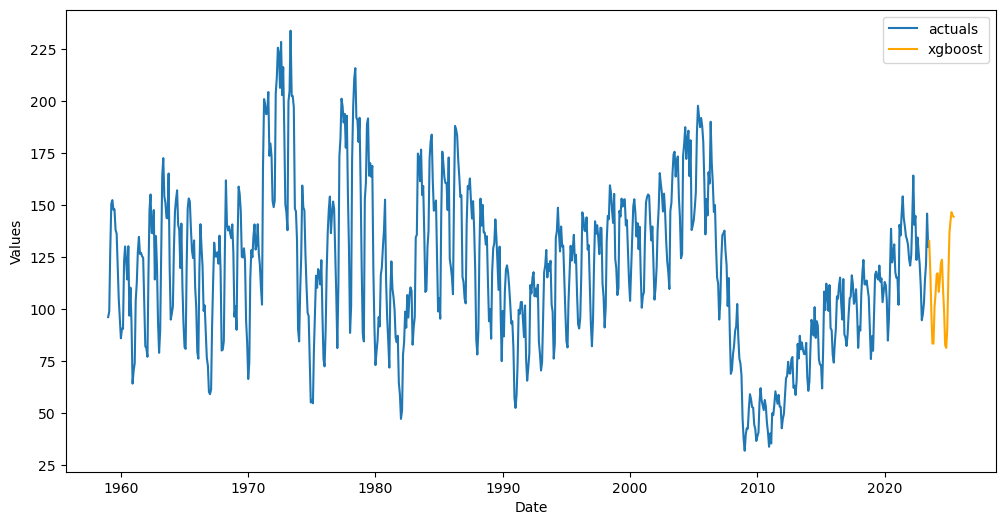

In [13]:
f_new.plot()
plt.show()

### View the in-sample predictions

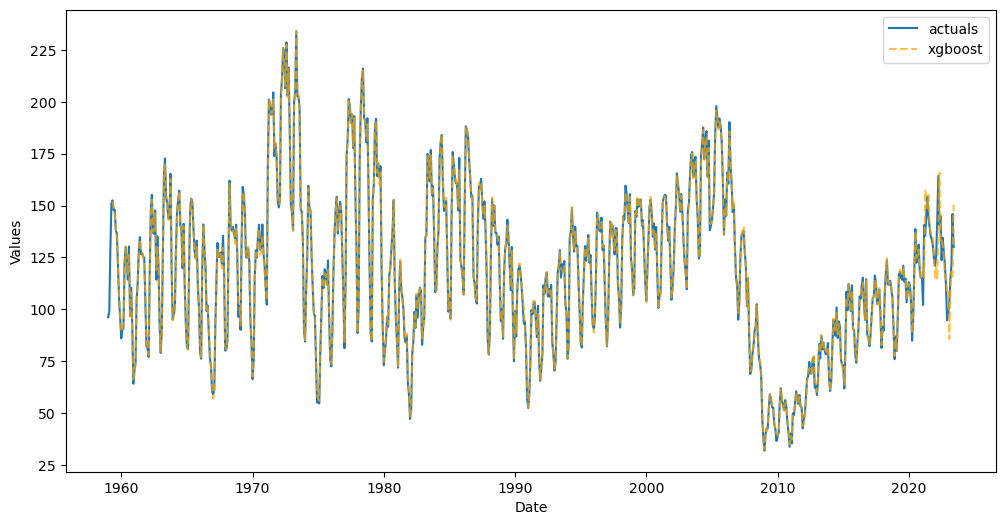

In [14]:
f_new.plot_fitted()
plt.show()

In the below plot, the model has seen all observations until December, 2020. From January, 2021 through June, 2023, it is seeing those observations for the first time, but because it has the actual y observations, its predictions are expected to be more accurate than the forecast into the unknown horizon.

## Predict over a specific date range
- Instead of storing the model info into the new `Forecaster` object, you can instead get predicted output over a specific date range.

In [15]:
preds = f_new.transfer_predict(
    transfer_from = f,
    model = 'xgboost',
    dates = pd.date_range(start='2021-01-01',end='2023-12-31',freq='MS'),
    save_to_history=False,
    return_series=True,
)
preds

2021-01-01    120.318314
2021-02-01    120.473404
2021-03-01    115.407341
2021-04-01    157.288330
2021-05-01    153.468536
2021-06-01    147.960663
2021-07-01    155.123367
2021-08-01    140.154938
2021-09-01    136.826553
2021-10-01    136.359772
2021-11-01    135.250488
2021-12-01    123.324181
2022-01-01    115.370422
2022-02-01    120.271683
2022-03-01    114.077393
2022-04-01    135.175552
2022-05-01    165.775436
2022-06-01    133.342361
2022-07-01    134.336517
2022-08-01    130.473236
2022-09-01    125.777290
2022-10-01    115.409798
2022-11-01    115.018028
2022-12-01    107.763420
2023-01-01    108.356743
2023-02-01     85.753906
2023-03-01    108.001480
2023-04-01    118.080322
2023-05-01    114.959618
2023-06-01    150.376816
2023-07-01    132.745132
2023-08-01    118.636002
2023-09-01     98.327621
2023-10-01     83.459045
2023-11-01     83.448402
2023-12-01    100.991570
dtype: float32

From January  through June, 2021, the predictions are considered in-sample, although the model has never previously seen them (it predicted using the actual y observations over that timespan, and that is a form of leakage for auto-regressive time series models). The rest of the predictions are truly out-of-sample.

## Transfer Predict in a Pipeline
- We can use auto-transformation selection and pipelines to apply predictions from a fitted model into a new Forecaster object. This can be good to apply when new data frequently comes through and you don't want to refit models.

### Find optimal set of transformations

In [16]:
transformer, reverter = find_optimal_transformation(f,verbose=True)

Using xgboost model to find the best transformation set on 1 test sets, each 24 in length.
All transformation tries will be evaluated with 12 lags.
Last transformer tried:
[]
Score (rmse): 20.58674859410421
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'loess': True})]
Score (rmse): 16.0610904656786
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 1})]
Score (rmse): 17.966964748692096
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 2})]
Score (rmse): 16.123002151983062
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'loess': True}), ('DeseasonTransform', {'m': 12, 'model': 'add'})]
Score (rmse): 20.748404440789933
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'loess': True}), ('DiffTransform', 1)]
Score (rmse)

### Fit the first pipeline

In [17]:
def forecaster(f):
    f.auto_Xvar_select()
    f.ingest_grid('xgboost')
    f.limit_grid_size(10)
    f.cross_validate(k=3,test_length=48)
    f.auto_forecast()

In [18]:
pipeline = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Forecast',forecaster),
        ('Revert',reverter),
    ]
)

f = pipeline.fit_predict(f)

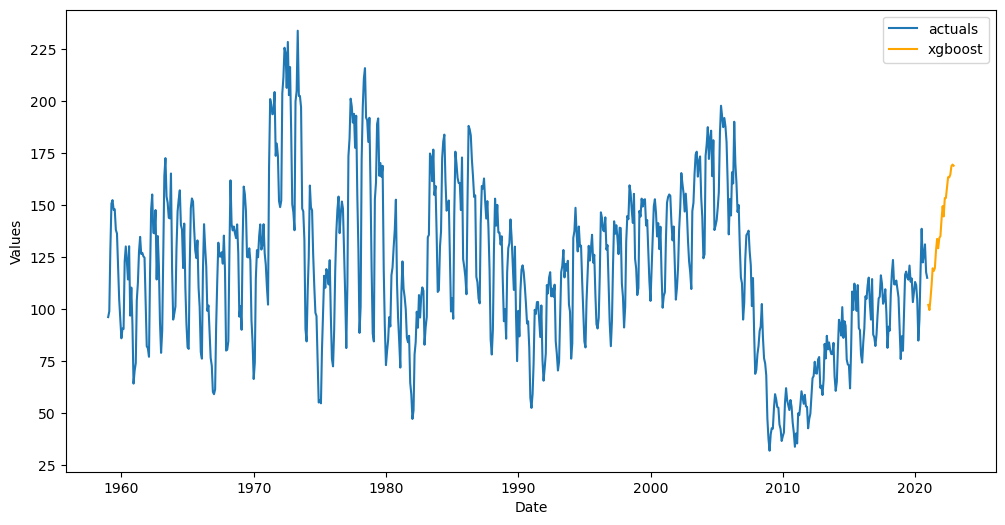

In [19]:
f.plot()
plt.show()

### Predict new data

In [20]:
def transfer_forecast(f,transfer_from):
    infer_apply_Xvar_selection(infer_from=transfer_from,apply_to=f)
    f.transfer_predict(transfer_from=transfer_from,model='xgboost')

In [21]:
pipeline_new = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Transfer Forecast',transfer_forecast),
        ('Revert',reverter),
    ]
)

f_new = pipeline_new.fit_predict(f_new,transfer_from=f) # even though it says fit, no model actually gets fit in the pipeline

In [22]:
#f_new.transfer_cis(transfer_from=f,model='xgboost') # this is how to transfer confidence intervals

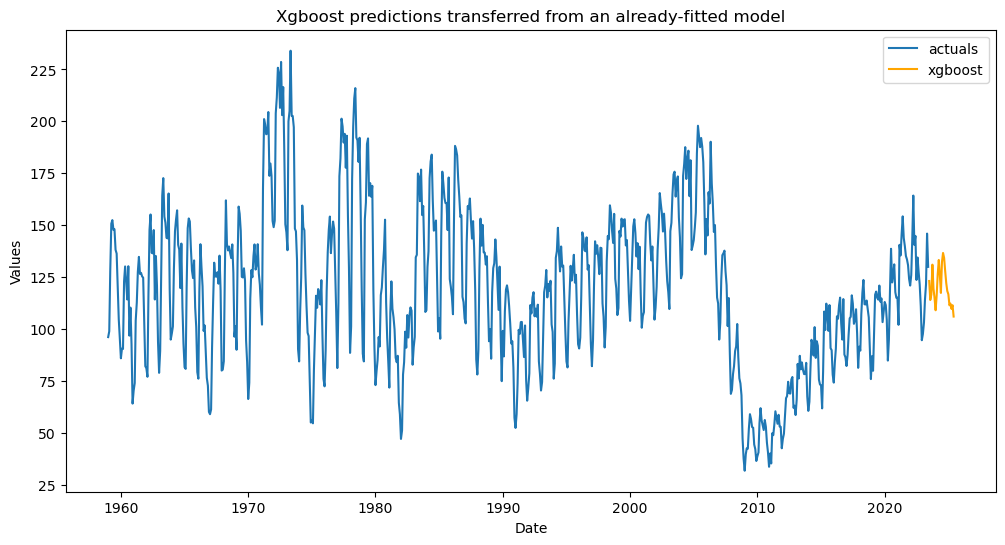

In [23]:
f_new.plot()
plt.title('Xgboost predictions transferred from an already-fitted model') 
plt.show()